In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F

In [ ]:
# opening our names file
with open('../names.txt','r') as n:
    words = n.read()
    words = words.splitlines()
words[:5]    

In [ ]:
# This is like building our character level library of chars to int and back
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {s:i for i,s in stoi.items()}
itos

In [803]:
# lets build our x and y taking the block_size/context at a time and storing the next character as per context in y.
block_size = 4
x,y = [],[]

for w in words:
    context = [0]*block_size

    for ch in w+'.':
        ix = stoi[ch]
        x.append(context)
        y.append(ix)

        context = context[1:] + [ix]

# converting to tensors for efficient operation 
x = torch.tensor(x)
y = torch.tensor(y)

In [ ]:
g = torch.Generator().manual_seed(5)
w1 = torch.randn((27*block_size,27),generator=g) * 0.01

# Bias is a learnable parameter that lets each neuron adjust when it activates — its own personal "activation threshold" or how much to fire?
b1 = torch.zeros(27,requires_grad=True)

# we're embedding each of our 27 chars in a 2-dim space
c = torch.randn((27,2),requires_grad=True)
params = [w1,b1,c]

# we tell pytorch that we require our params to track gradients, and populate the tree using chain rule
for p in params:
    p.requires_grad = True

## Why do we need a x by 27 weight matrix? And why not x by 1?
The answer lies in how many possible outputs do we expect for each input? It'll be a probability matrix of 27Chars and we'll see which is most likely to follow.


Probability distribution over the next character (again, 27 possibilities).
"Given char c, look at row c in W, and use the max (or sample from softmax) to choose the most likely next character."


### Think of w1 as being divided into 3 blocks, each of size (27, 27):
1. The first block (rows 0–26) is for the first character in the context.
2. The second block (rows 27–53) is for the second character.
3. The third block (rows 54–80) is for the third character.

## So, for a context [c0, c1, c2]:
1. w1[c0] picks the row for the first character.
2. w1[27 + c1] picks the row for the second character (shifted by 27).
3. w1[54 + c2] picks the row for the third character (shifted by 54).

In [ ]:
xenc = torch.nn.functional.one_hot(torch.Tensor(x),num_classes=27)
xflat = xenc.view(-1,27*block_size).float()
xenc.shape,xflat.shape

In [651]:
# training loop with just weights and no optim
for i in range(50000):
    out = (w1[x[:,0]]+ w1[27+x[:,1]]+ w1[27+27+x[:,2]]) + b1 
    counts = torch.exp(out)
    probs = counts / counts.sum(dim=1,keepdim=True)
    loss = -probs[torch.arange(len(y)),y].log().mean() + 0.01*(w1**2).mean() # --> This is a regularisation term that punishes our model for having bigger weights. During gradient based learning, models can become very-very greedy to try and overfit, this term penalises the model for having too big weights by increasing loss.

    w1.grad,b1.grad = None, None

    loss.backward()

    lr = 10 if loss.item() > 2.6 else 1
    w1.data += (-lr*w1.grad)
    b1.data += (-lr*b1.grad)

    if i%1000 == 0:
        print(loss.item())


IndexError: index 14 is out of bounds for dimension 0 with size 6

In [ ]:
# we will need to change our initialisations to support our embedding vector c
g = torch.Generator().manual_seed(5)

# we're embedding each of our 27 chars in a 2-dim space
c = torch.randn((27,10),generator=g)

# 6,100 cause embedding will be of shape torch.Size([228146, 3, 2]), so we will get 2*3 for 2dimensional inputs and 3 of them by 100 neurons
input_to_w1 = c.shape[1] * block_size
w1 = torch.randn((input_to_w1,300),generator=g) * 0.01 
w2 = torch.randn((300,27),generator=g) * 0.01

# Bias is a learnable parameter that lets each neuron adjust when it activates — its own personal "activation threshold" or how much to fire?
b1 = torch.zeros(300)
b2= torch.zeros(27)  


params = [w1,b1,w2,b2,c]

# we tell pytorch that we require our params to track gradients, and populate the tree using chain rule
for p in params:
    p.requires_grad = True

In [856]:
input_to_w1 = c.shape[1] * block_size

In [805]:
sum(p.nelement() for p in params)

10497

In [815]:
# Now lets implement a Embedding vector C and use it.
emb = c[x]
emb.shape

torch.Size([228146, 4, 10])

In [812]:
# lets create mini-batches cause without it we're doing forward pass, backward and update on the full dataset, it'll be faster to iterate in batches
# The speed difference in mini batches is insane, its like 100X faster or something
batch_size = 64

In [ ]:
for i in range(300000):
    # constructing our batches
    ix = torch.randint(0,x.shape[0],(batch_size,))

    # forward pass
    emb = c[x[ix]]
    h = torch.tanh(emb.view(-1,input_to_w1) @ w1 + b1)
    logits = (h @ w2) +b2
    # counts = torch.exp(logits)
    # probs = counts / counts.sum(dim=1,keepdim=True)
    # loss = -probs[torch.arange(len(y)),y].log().mean()
    loss = F.cross_entropy(logits,y[ix]) + 0.01 * (w1**2).mean()
    # if i%1000 == 0:
    print(loss.item())

    # zeroing grads
    for p in params:
        p.grad = None

    # backward pass
    loss.backward()  

    #lr decay
    lr = 0.01 if i > 100000 else 0.001
    # update
    for p in params:
        p.data += -lr * p.grad
    
    # if loss.item() < 1.5:
    #     break

2.189067840576172
1.7931241989135742
1.9576661586761475
1.9205832481384277
1.8873097896575928
1.7856166362762451
1.5759387016296387
2.0290472507476807
1.7998160123825073
2.2254385948181152
2.005516290664673
2.0937321186065674
1.7683916091918945
1.9428859949111938
1.9095048904418945
1.853501558303833
1.9721471071243286
1.7589648962020874
2.1928975582122803
2.0050525665283203
2.0532987117767334
2.077396869659424
1.7305909395217896
1.9153602123260498
1.6655893325805664
2.1046273708343506
1.9395278692245483
1.8384145498275757
1.8307303190231323
2.0130393505096436
1.7854840755462646
1.9280061721801758
2.044323682785034
2.1503188610076904
1.9732755422592163
2.143693685531616
1.9549726247787476
1.8471630811691284
1.8477962017059326
1.9865388870239258
1.858581304550171
1.9723026752471924
1.9394222497940063
1.6993540525436401
2.0237832069396973
2.01491117477417
1.913987398147583
2.078428030014038
1.8781898021697998
2.1891963481903076
2.1466195583343506
1.8900657892227173
2.1387038230895996
2.23

In [858]:
emb = c[x]
h = torch.tanh(emb.view(-1,input_to_w1) @ w1 + b1)
logits = (h @ w2) +b2
loss = F.cross_entropy(logits,y)
loss

tensor(1.9586, grad_fn=<NllLossBackward0>)

In [ ]:
print(f"1. The loss after 50K iterations proper w1 initialisation but no other optimisations is 2.271 and accuracy is 28.44%")
print(f"2. The loss after using context = 4, 500K iterations proper w1 initialisation, batching and using a C vector-space(27,10), and a bigger hidden layer (6,300) to represent our chars is 1.9586 and accuracy is 38.02%")

1. The loss after 50K iterations proper w1 initialisation but no other optimisations is 2.271 and accuracy is 28.44%
2. The loss after 50K iterations proper w1 initialisation, batching and using a C vector-space, and a bigger hidden layer (6,300) to represent our chars is 1.495 and accuracy is 28.44%


# Here, we keep a track of all the iterations and lessons that we've learned along the way.
1. The loss after 50K iterations proper w1 initialisation but no other optimisations is 2.271 and accuracy is 28.44%
2. The loss after 50K iterations proper w1 initialisation, batching and using a C vector-space to represent our chars is 1.495 and accuracy is 29.11%

In [699]:
probs.max(1)[1]

tensor([21,  0,  0,  ..., 12, 12,  0])

In [ ]:
(probs.max(1)[1] == y).float().mean()

tensor(0.0374)

In [836]:
# we need to measure accuracy differently for our method 2
emb = c[x]
h = torch.tanh(emb.view(-1,40) @ w1 + b1)
logits = (h @ w2) +b2
counts = torch.exp(logits)
probs = counts / counts.sum(dim=1,keepdim=True)
(probs.max(1)[1] == y).float().mean()

tensor(0.3802)

In [859]:
g = torch.Generator().manual_seed(2147483647+10)
for _ in range(10):
    context = [0] * block_size
    out = []
    while True:
        # Compute logits for the current context only
        emb = c[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ w1 + b1)
        logits = (h @ w2) +b2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i]for i in out))

carmah.
amoriq.
khirmley.
taty.
skanden.
jazhukwu.
perric.
kaeli.
nerosea.
chaily.


In [708]:
probs[0].sum()

tensor(1.0000, grad_fn=<SumBackward0>)

1. We generated these names in 1st iteration of our NN \
[careah
amille
khismrichelty
salays
errahnel
delyaha
kaqui
nelenia
chaiiv
kaleig]

2. We generated these names in 1st iteration of our NN \
[carmah.
amoriq.
khirmley.
taty.
skanden.
jazhukwu.
perric.
kaeli.
nerosea.
chaily.]

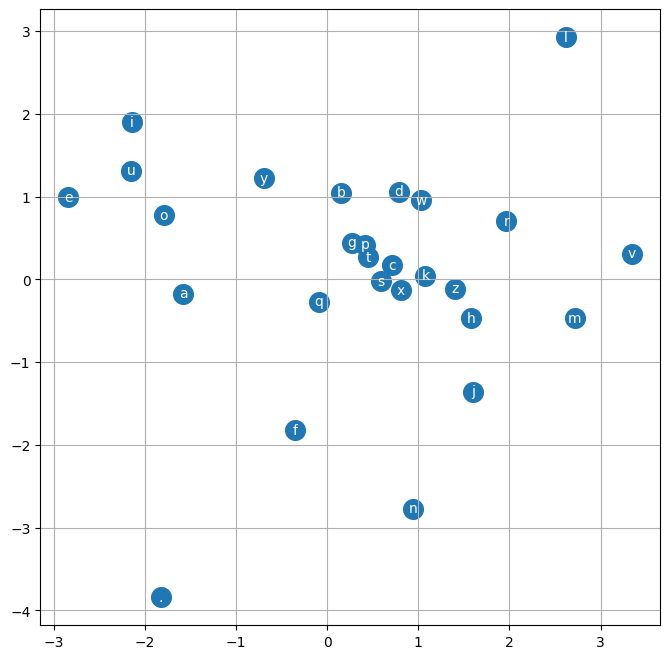

In [799]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.scatter(c[:,0].data,c[:,1].data,s=200)
for i in range(c.shape[0]):
    plt.text(c[i,0].item(),c[i,1].item(),itos[i],ha='center',va='center',color='white')
plt.grid('minor')

In [794]:
c[stoi['.']]

tensor([-1.8183, -3.8307], grad_fn=<SelectBackward0>)

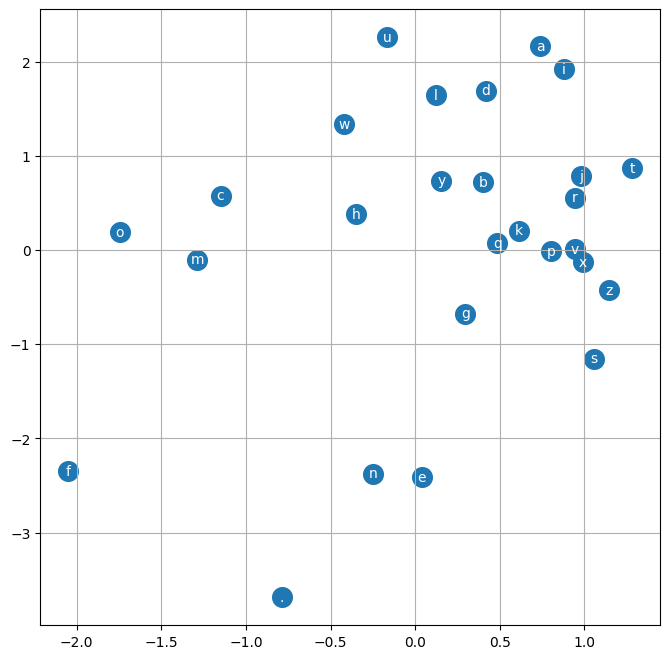

In [758]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.scatter(c[:,0].data,c[:,1].data,s=200)
for i in range(c.shape[0]):
    plt.text(c[i,0].item(),c[i,1].item(),itos[i],ha='center',va='center',color='white')
plt.grid('minor')

In [875]:
h = 0.00001
a = 3
b = 2
c = a + b 
c_n = (a + h) + b 
dc = (c_n-c)/h
c,c_n,dc.__round__(2)

(5, 5.00001, 1.0)

In [ ]:
c = 8
b = 4
m = 1
# m --> b = 4
# b --> c = 2
# m --> c = 8, the multiple of above 2 rates

8.0